In [65]:
import torch

import importer
import numpy as np
import matplotlib.pyplot as plt
import torch as t
from torch.distributions import Normal, Categorical, Bernoulli
from torch.distributions import MultivariateNormal as MvNormal

# Creating a Classifier

The goal of this notebook will be to create a highly accurate classifier between MTB rides and road rides. Although this differentiation is not recorded explicitly in the dataset a field 'Activity Gear' records which bike I was riding. When I go for an MTB ride I will always use my mountain bike, the 'Roscoe 8'. Similarly, for road rides, I will always use the 'Carrera Zelos' So if the classifier can model which bike I am riding then it can model which type of ride I am doing.

To achieve this goal will require a three stage approach: pre-processing, feature selection, and classification.


## Pre-processing

In the interest of brevity, all pre-processing for this dataset has been done in the importer module inside this repository. This module servers a few purposes:
- Removes all rows where there is a column containing no data.
- Allows partitioning of data
- Converts the 'Activity Date' field into the seconds from the Unix epoch

A limitation of this classifier is that it will only be able to use numerical data. This can immediately remove all attributes that are strings or booleans. We can also remove any attributes which where only recorded for a few activities.

In [66]:
data_set = importer.Data()

# Get all headers that contain numeric data
headers = []
for i in range(len(data_set.headers)):
    if data_set.types[i] != 'string' and data_set.types[i] != 'bool':
        headers.append(data_set.headers[i])

# Remove headers which have not been recorded for many activities
for header in headers:
    if len(data_set.get_data([header])[header]) < 100:
        headers.remove(header)

headers.append('Activity Gear')

features = data_set.get_data(headers)
print('This leaves us with the following list of', len(headers), 'headers: ', headers, '\n')
print('This reduces the number of activities to ', len(features[headers[0]]))

This leaves us with the following list of 39 headers:  ['Activity ID', 'Elapsed Time', 'Distance', 'Elapsed Time2', 'Moving Time', 'Distance3', 'Max Speed', 'Average Speed', 'Elevation Gain', 'Elevation Loss', 'Elevation Low', 'Elevation High', 'Max Grade', 'Average Grade', 'Average Watts', 'Calories', 'Perceived Exertion', 'Perceived Relative Effort', 'From Upload', 'Weather Observation Time', 'Weather Condition', 'Weather Temperature', 'Apparent Temperature', 'Dewpoint', 'Humidity', 'Weather Pressure', 'Wind Speed', 'Wind Gust', 'Wind Bearing', 'Precipitation Intensity', 'Sunrise Time', 'Sunset Time', 'Moon Phase', 'Precipitation Probability', 'Cloud Cover', 'Weather Visibility', 'UV Index', 'Weather Ozone', 'Activity Gear'] 

This reduces the number of activities to  67


## A basic classifier

The goal of the classifier is to predict a distribution over the defined classes $y_\lambda$ based on an input $\textbf{x}_\lambda$. In our case we only have two classes, so we can model this using a Bernoulli distribution.

$$P(y_\lambda|\textbf{x}_\lambda)=Bernoulli(y_\lambda;p=\sigma(\textbf{x}_\lambda\cdot\textbf{w}))$$
$$P(\textbf{y}|\textbf{X})=\prod_\lambda P(y_\lambda|\textbf{x}_\lambda) = Bernoulli(y_\lambda;p=\sigma(\textbf{Xw}))$$

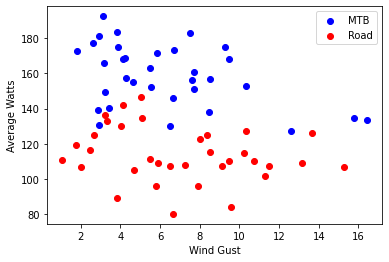

In [67]:
x_data = 'Wind Gust'
y_data = 'Average Watts'

features1 = importer.partition(features, 'Activity Gear')

X_mtb = features1['Roscoe 8'][x_data]
Y_mtb = features1['Roscoe 8'][y_data]
X_road = features1['Carrera Zelos'][x_data]
Y_road = features1['Carrera Zelos'][y_data]
fig0, ax = plt.subplots()
ax.scatter(X_mtb, Y_mtb, c='blue', label='MTB')
ax.scatter(X_road, Y_road, c='red', label='Road')
ax.set_xlabel(x_data)
ax.set_ylabel(y_data)
ax.legend()
plt.show()

In [68]:
# Format the data so that it can be used by PyTorch
X, Y = importer.separate_x_y(features, 'Activity Gear')
Y, class_code = importer.code_classes(Y)
X = t.tensor(X).float()
Y = t.tensor(Y).float()
Y = t.unsqueeze(Y, 0).t()

# Add a 1 value to the end of each activity to represent an offset from the origin
X_w = t.cat([X, t.ones(X.shape[0], 1)], -1)

# Split the data into training and testing
partition = 50
X_train = X_w[:partition, :]
Y_train = Y[:partition, :]
X_test = X_w[partition:, :]
Y_test = Y[partition:, :]

# Define a weight for how much each feature effects the classification boundary
W = t.randn((39,1), requires_grad=True)/100

In [69]:
for i in range(50000):
    L = Bernoulli(logits=X_train@W).log_prob(Y_train).sum()

    dW = t.autograd.grad(outputs=L, inputs=(W,))[0]
    if 0==i % 1000:
        print(L.item())
    W.data += 0.001*dW

-1203414272.0
-3.176886291220398e+18
-2.8387097747432407e+18
-2.809817357944357e+18
-3.4412237299447235e+18
-5.148414268793684e+18
-2.5509967188123976e+18
-2.5219492708739973e+18
-2.4974290620629647e+18
-2.758970442717856e+18
-2.824032119146152e+18
-3.438703924171768e+18
-5.138838072271569e+18
-2.5566311661489357e+18
-5.131467496074772e+18
-2.538044746715103e+18
-2.508993450486006e+18
-2.774204176320692e+18
-3.01735347622196e+18
-2.809173319008387e+18
-3.4393880952821514e+18
-5.144573124922049e+18
-2.543681393074897e+18
-2.5225523530018324e+18
-2.7883403224411013e+18
-2.855788763735392e+18
-3.4751895682720727e+18
-3.4368691141429166e+18
-3.4097315179019633e+18
-2.557241944858165e+18
-2.528200269355811e+18
-2.791468707900031e+18
-2.7734273713556685e+18
-2.732968916866302e+18
-2.7960509226087875e+18
-5.172175814581551e+18
-5.125453167470838e+18
-5.102756498694472e+18
-2.5127199702704456e+18
-2.7763421766809027e+18
-2.7470335947309056e+18
-2.810282451362906e+18
-2.7813735418896056e+18
-3.

In [ ]:
def class_error(X, Y):
    Py = Bernoulli(logits=X@W)
    pred = 0.5 < Py.probs
    N_correct = (pred == Y).sum()
    print(f"{N_correct}/{X.shape[0]} = {100.*N_correct/X.shape[0]}%")

print("Training correct")
class_error(X_train, Y_train)

print("Test correct")
class_error(X_test, Y_test)

/tmp/ipykernel_30453/2631319932.py:19: UserWarning: No contour levels were found within the data range.
  ax.contour(x0s, x1s, 0.5<ps);


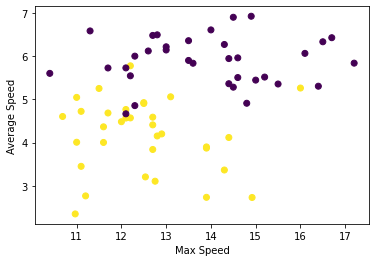

In [80]:
feature1 = 6
feature2 = 7

fig, ax = plt.subplots()
ax.set_xlabel(headers[feature1])
ax.set_ylabel(headers[feature2])
ax.scatter(X[:, feature1], X[:, feature2], c=Y)

x0range = t.linspace(*ax.get_xlim(), 500)
x1range = t.linspace(*ax.get_ylim(), 500)

x0s, x1s = t.meshgrid(x0range, x1range)
xs = t.stack([x0s, x1s, t.ones(500, 500)], -1)

W_reduce = t.tensor([W[feature1], W[feature2], W[len(W)-1]])
W_reduce = t.unsqueeze(W_reduce, 0).t()

ps = Bernoulli(logits=xs@W_reduce.detach()).probs[:, :, 0]
ax.contour(x0s, x1s, 0.5<ps);

## Feature Selection

Now that we have a preprocessed subset of the dataset we need to perform **dimensionality reduction** to remove any features which will not be as useful to the classifier, this can be done via ** Heuristic Feature Selection**. To do this it is assumed that the features are independent (although in reality this is not the case) and a top-down approach can be taken by removing the worst features.